# PROJETO 2 DE CIÊNCIA DOS DADOS

Integrantes: Amanda Colucci, Gustavo Borges, João Pedro Oliveira, Sophia Braz

Prof. Fabio Ayres e Maciel Vidal

Truma A - 2° semestre

### Importando as bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import numpy as np
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import tree
from sklearn.metrics import confusion_matrix 
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns

### Encontrando o arquivo:

In [2]:
file = 'Dataset-Kickstarter-projects-2018.csv'
if file in os.listdir():
    print(f'Encontramos o arquivo {file}, podemos prosseguir!')
else:
    print(f'Não encontramos o arquivo {file} no diretório {os.getcwd()}!')

Encontramos o arquivo Dataset-Kickstarter-projects-2018.csv, podemos prosseguir!


### Introdução:

Procurando no site Kaggle por datasets a serem analisados, encontramos um dataset que contém informações sobre financiamentos coletivos do site de crowdfunding do Kickstarter. O dataset escolhido é bastante rico em informações sobre diversos projetos, tornando-o ideal para ser analisado aplicando diferentes técnicas. Decidimos que o objetivo principal que conduzirá o desenvolvimento do projeto, é: A partir de diversas features do dataset, gostariamos de prever uma variável target qualitativa a qual pode assumir o valor "successful" (conseguiu arrecadar a meta proposta dentro do espaço de tempo previsto) ou "failed" (não conseguiu arrecadar a meta proposta dentro do espaço de tempo previsto). 


As colunas do nosso dataset são:
    
  - **ID** sequência de números única a cada projeto, feita pelo criador do dataset (qualitativa nominal)
  - **Name** nomes dos projetos do kickstarter (qualitativa Nominal)
  - **Main Category** categoria mais abrangente relacionada a proposta de cada projeto (qualitativa nomial)
  - **Category** sub-categoria relacionada a proposta de cada projeto (qualitativa nomial)
  - **Currency** moeda usada na arrecadação de cada projeto (qualitativa nomial)
  - **Deadline** data limite da arrecadação de cada projeto (quantitativa contínua)
  - **Goal** quantidade proposta na arrecadação em moeda local (quantitativa discreta)
  - **Launched** data de lançamento de cada projeto (quantitativa contínua)
  - **Pledged** quantidade de dinheiro arrecadado em moeda local (quantitativa discreta)
  - **State** estado atual do projeto (qualitativa ordinal)
  - **Backers** número de apoiadores do projeto (quantitativa discreta)
  - **Country** paises de origem do projeto (qualitativa nominal)
  - **USD pledged** quantitade de dinheiro arrecadado em USD, conversão feita pelo Kickstarter (quantitativa discreta)
  - **USD pledged Real** quantidade de dinheiro arrecadado em USD, conversão feita pelo dono do Dataset (quantitativa discreta)
  - **USD goal real** quantidade proposta na arrecadação em  USD, conversão feita pelo dono do Dataset (quantitativa discreta) 
    

### Lendo o arquivo csv: 

In [3]:
dataset = pd.read_csv(file)
dataset.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
# Vendo os tipos de variáveis do dataset
dataset.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

### Mudando as variáveis do dataset

Ajustando os tipos de variáveis para que conseguimos analisá-las adequadamente. Não alteramos o tipo de variável da coluna 'State' pois os modelos não aceitam o tipo categórico. 

In [5]:
dataset['main_category'] = dataset.loc[:,'main_category'].astype('category')
dataset['currency'] = dataset.loc[:,'currency'].astype('category')
dataset['deadline'] = dataset.loc[:,'deadline'].astype('datetime64')
dataset['launched'] = dataset.loc[:,'launched'].astype('datetime64')
#dataset['state'] = dataset.loc[:,'state'].astype('category')
dataset['country'] = dataset.loc[:,'country'].astype('category')

dataset.dtypes

ID                           int64
name                        object
category                    object
main_category             category
currency                  category
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                   category
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

Cronstruindo a coluna 'delta_time', sendo essa o tempo de duracao da campanha de cada projeto, através da associacao das colunas 'launched_Dates' e 'deadline'. Também separamos a coluna 'launched' para podermos trabalhar com o ano do lançamento e o mês separadamente. 

In [6]:
dataset['launched_Dates'] = pd.to_datetime(dataset['launched']).dt.date

dataset['deadline'] = pd.to_datetime(dataset['deadline']).dt.date

dataset['delta_time'] = dataset['deadline'] - dataset['launched_Dates']

dataset['delta_time'] = dataset['delta_time'].dt.days

dataset['launched_Year'] = pd.to_datetime(dataset['launched']).dt.year

#associando a categoria a ser analisada:
dataset['launched_Year'] = dataset.loc[:,'launched_Year'].astype('category')

dataset['launched_Month'] = pd.to_datetime(dataset['launched']).dt.month


Decidimos dropar algumas colunas que representam a mesma variável em escalas diferentes ou são desnecessárias para a nossa análise. Por exemplo, as variáveis que são coletadas após o termino da campanha.


In [7]:
dataset = dataset.drop(columns = ['ID', 'name', 'currency', 'pledged', 'usd pledged', 'category', 'launched', 'deadline', 'backers', 'launched_Dates', 'goal'])

Como nossa pergunta principal abrange apenas o resultado de sucesso ou falha, filtramos as outras opções da coluna de estado atual, assim, so obtendo as que seriam suficientes para responder nossa pergunta.

In [8]:
# filtrando a coluna state
filtra_sucesso = dataset['state'] == 'successful'
filtra_falha = dataset['state'] == 'failed'
dataset = dataset.loc[(filtra_sucesso | filtra_falha ),:]
dataset

,main_category,state,country,usd_pledged_real,usd_goal_real,delta_time,launched_Year,launched_Month
0,Publishing,failed,GB,0.0,1533.95,59,2015,8
1,Film & Video,failed,US,2421.0,30000.00,60,2017,9
2,Film & Video,failed,US,220.0,45000.00,45,2013,1
3,Music,failed,US,1.0,5000.00,30,2012,3
5,Food,successful,US,52375.0,50000.00,35,2016,2
...,...,...,...,...,...,...,...,...
378654,Food,failed,US,154.0,6500.00,30,2017,3
378657,Film & Video,failed,US,155.0,1500.00,27,2011,6
378658,Film & Video,failed,US,20.0,15000.00,46,2010,7
378659,Technology,failed,US,200.0,15000.00,31,2016,1


In [9]:
dataset.dtypes
#verificando as categorias

main_category       category
state                 object
country             category
usd_pledged_real     float64
usd_goal_real        float64
delta_time             int64
launched_Year       category
launched_Month         int64
dtype: object

### Análise Exploratória do DataSet

Checando para ver se o dataset esta balanceado, quando as variáveis target

In [10]:
dataset.state.value_counts(normalize = True)

failed        0.596123
successful    0.403877
Name: state, dtype: float64

#### Análise das categorias principais.

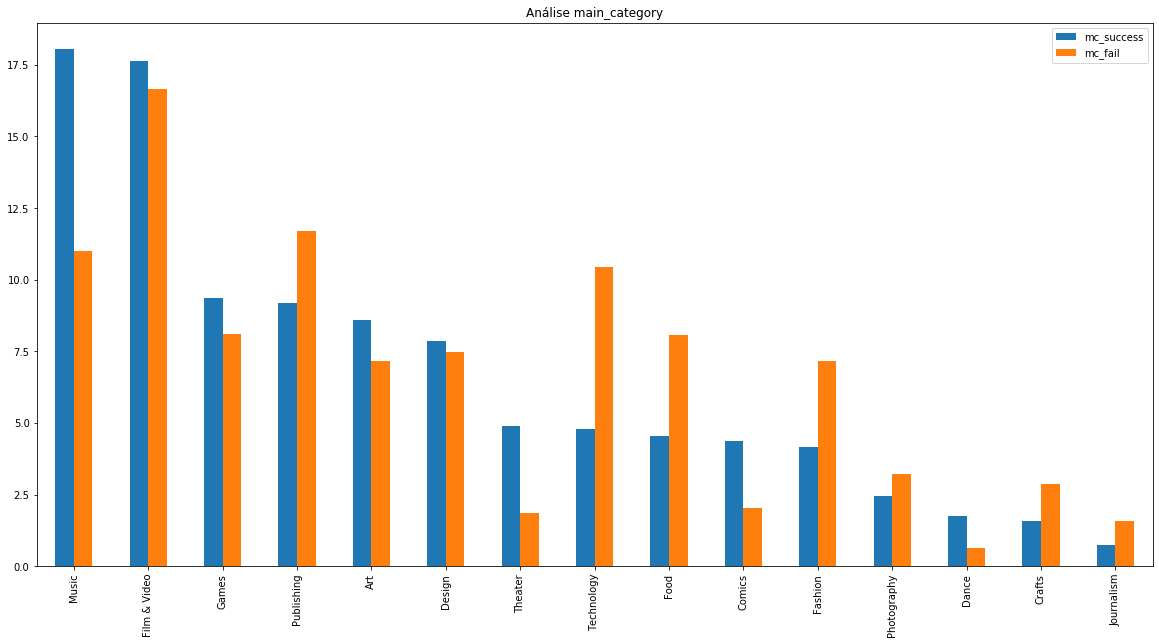

In [11]:
mc = pd.DataFrame()
mc['mc_success'] = dataset.loc[filtra_sucesso,'main_category'].value_counts(normalize = 'index')*100
mc['mc_fail'] = dataset.loc[filtra_falha,'main_category'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_mc = mc.plot.bar(ax = ax1, title = 'Análise main_category')

In [12]:
verificacao_1 = pd.crosstab(dataset.main_category, dataset.state, normalize = 'index', margins = True)*100
#fizemos crosstab para para associar duas variáveis qualitativas (state, categoria principal)

Para melhor visualização, plotamos um gráfico, heatmap, a partir da biblioteca seaborn

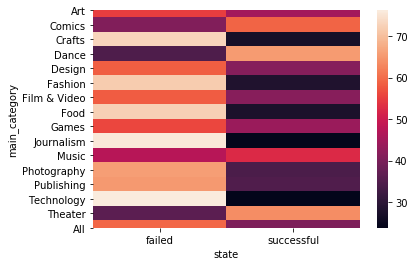

In [13]:
sns.heatmap(verificacao_1)

A partir dos gráficos acima, é possível ver que do total de categorias, mais da metade obtiveram sucesso, sendo a categoria com maior taxa de sucesso a de musica, e a de menor sucesso a de jornalismo. Já a de falha, sendo minoria, a categoria com maior taxa é a de filme e video, e a de menos é a de dança. Também é possível observar que nas categorias de Fotografia, Filme e Vídeo, Jogos e Design as taxas de sucesso e falha tem um valor muito próximo, indicando uma certa incerteza nesses resultados.

#### Análise dos países:

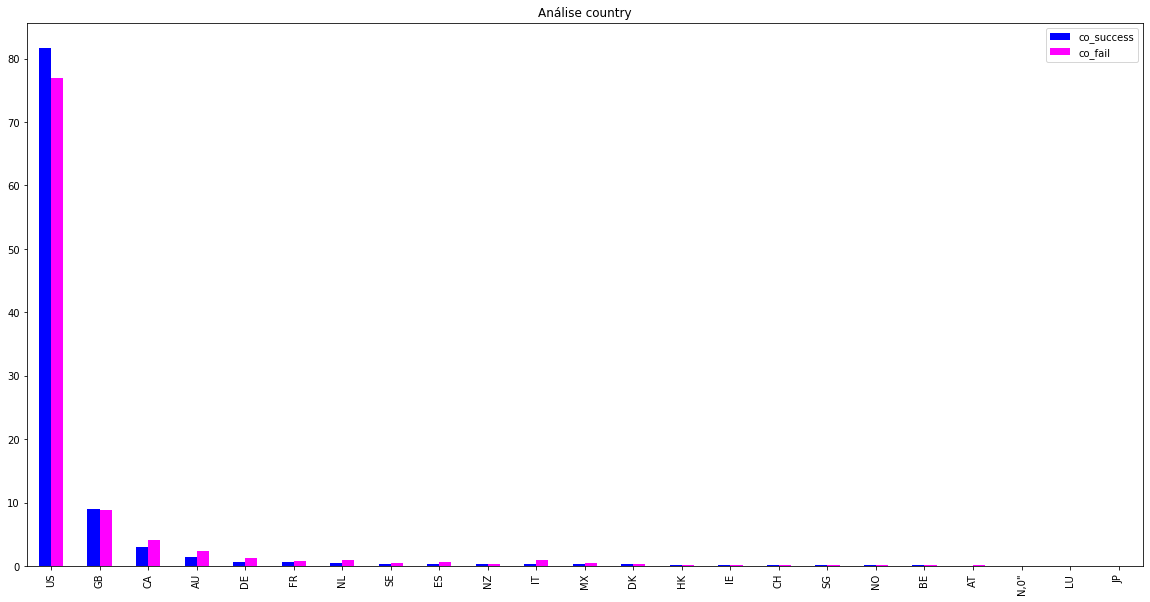

In [14]:
co = pd.DataFrame()
co['co_success'] = dataset.loc[filtra_sucesso,'country'].value_counts(normalize = 'index')*100
co['co_fail'] = dataset.loc[filtra_falha,'country'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_co = co.plot.bar(ax = ax1, title = 'Análise country', color = ['blue', 'magenta'])

Para melhor visualização, plotamos um gráfico, heatmap, a partir da biblioteca seaborn

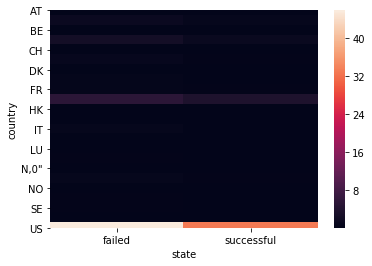

In [15]:
verificacao_2 = pd.crosstab(dataset.country, dataset.state, normalize = True)*100
sns.heatmap(verificacao_2)
#fizemos crosstab para para associar duas variáveis qualitativas (state, países)

Levando em consideração os países em que ocorrem as campanhas de financiamento coletivo, fica clara uma enorme diferença entre o número de campanhas feitas nos Estados Unidos e nos países restantes. Esse fato pode prejudicar nossa análise, já que os números dos Estados Unidos são extremamente grandes e os da maioria dos países são extremamente pequenos.

#### Análise dos anos de lançamento:

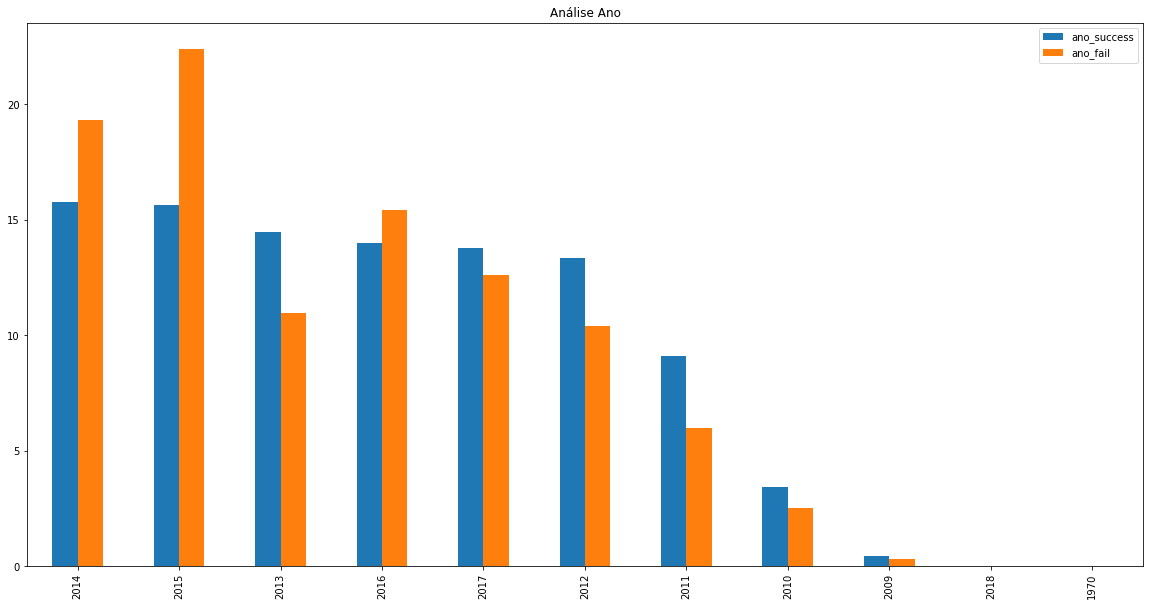

In [16]:
ano = pd.DataFrame()
ano['ano_success'] = dataset.loc[filtra_sucesso,'launched_Year'].value_counts(normalize = 'index')*100
ano['ano_fail'] = dataset.loc[filtra_falha,'launched_Year'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_ano = ano.plot.bar(ax = ax1, title = 'Análise Ano')

Para melhor visualização, plotamos um gráfico, heatmap, a partir da biblioteca seaborn

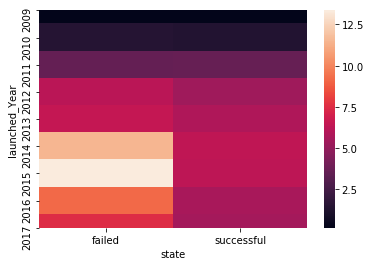

In [17]:
verificacao_3 = pd.crosstab(dataset.launched_Year, dataset.state, normalize = True)*100
sns.heatmap(verificacao_3)
#fizemos crosstab para para associar duas variáveis qualitativas (state, ano de lançamento)

Com essa análise podemos ver que ao longo dos anos um maior crescimento de lançamentos, com destaque nos anos de 2014 e 2015. Porém temos que levar em consideração também que nesses anos o ínidce de falha foi muito maior do que nos outros anos. No último ano analisado (2017), a taxa de sucesso ultrapassa a de falha. 

#### Análise dos meses de lançamento:

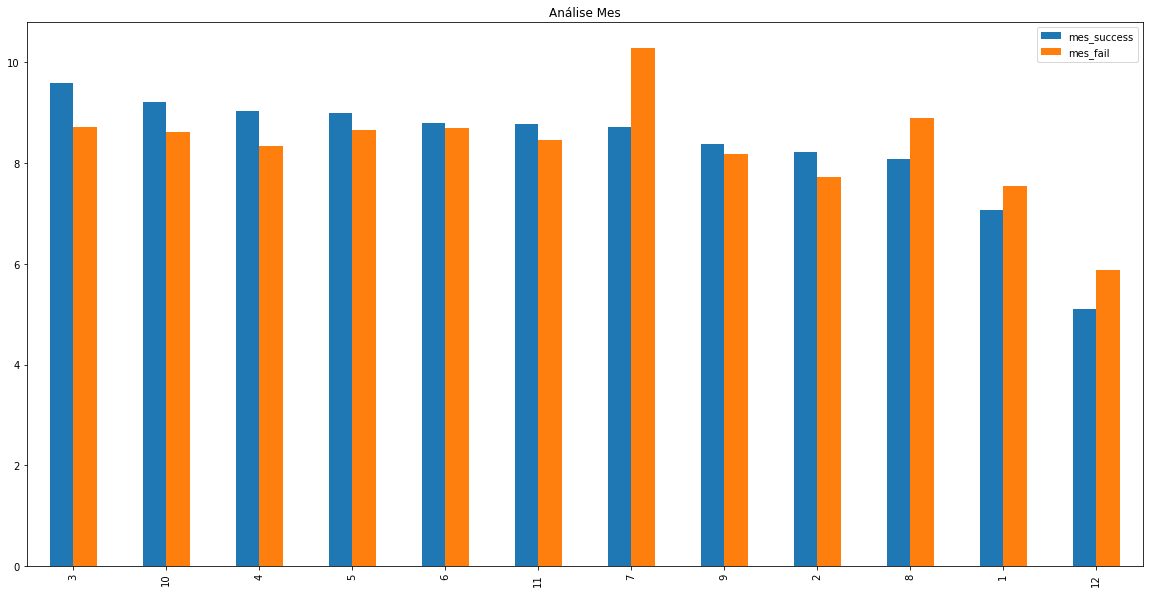

In [18]:
mes = pd.DataFrame()
mes['mes_success'] = dataset.loc[filtra_sucesso,'launched_Month'].value_counts(normalize = 'index')*100
mes['mes_fail'] = dataset.loc[filtra_falha,'launched_Month'].value_counts(normalize = 'index')*100

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot()
analise_mes = mes.plot.bar(ax = ax1, title = 'Análise Mes')

Para melhor visualização, plotamos um gráfico, heatmap, a partir da biblioteca seaborn


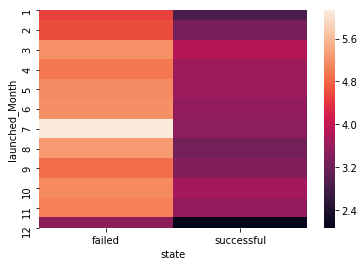

In [19]:
verificacao_4 = pd.crosstab(dataset.launched_Month, dataset.state, normalize = True)*100
sns.heatmap(verificacao_4)
#fizemos crosstab para para associar duas variáveis qualitativas (state, mes de lançamento)

Partindo para a análise dos meses, a primeira coisa a se notar é que os projetos que são lançados em Julho tem uma taxa de fracasso muito maior do que a dos outros meses. Nos meses de Janeiro e Dezembro, ambas as taxas são menores em comparação com os outros meses, e a taxa de fracasso costuma ser maior, o que pode se relacionar com a época festiva deste meses. 

#### Associando variáveis qualitativas com quantitativas

Utilizamos o groupby porque estamos associando uma variável quantitativa com um qualitativa.

In [20]:
a = dataset.groupby(['state']).describe()
a.dropna(inplace = True)
a.transpose()
a

usd_pledged_real                                              \
                      count          mean            std   min      25%   
state                                                                     
failed             197719.0   1320.603817    6820.249351  0.00     2.64   
successful         133956.0  22670.795231  151090.323352  0.79  2000.00   

                                            usd_goal_real                ...  \
                50%        75%          max         count          mean  ...   
state                                                                    ...   
failed       100.00    663.000    757352.94      197719.0  63174.742222  ...   
successful  5107.25  13232.075  20338986.27      133956.0   9532.853357  ...   

           delta_time       launched_Month                                     \
                  75%   max          count      mean       std  min  25%  50%   
state                                                                           
failed           40.0  92.0       197719.0  6.444712  3.306962  1.0  4.0  7.0   
successful       34.0  92.0       133956.0  6.374026  3.306591  1.0  4.0  6.0   

                       
            75%   max  
state                  
failed      9.0  12.0  
successful  9.0  12.0  

[2 rows x 32 columns]

Ajustando variáveis para plotar o histograma.

In [21]:
goal_success = dataset.loc[filtra_sucesso,'usd_goal_real']
goal_falha = dataset.loc[filtra_falha,'usd_goal_real']
pledged_success = dataset.loc[filtra_sucesso,'usd_pledged_real']
pledged_falha = dataset.loc[filtra_falha,'usd_pledged_real']
pledged_falha

0            0.0
1         2421.0
2          220.0
3            1.0
7          453.0
           ...  
378654     154.0
378657     155.0
378658      20.0
378659     200.0
378660     524.0
Name: usd_pledged_real, Length: 197719, dtype: float64

Fizemos o histograma para uma melhor visualização gráfica.

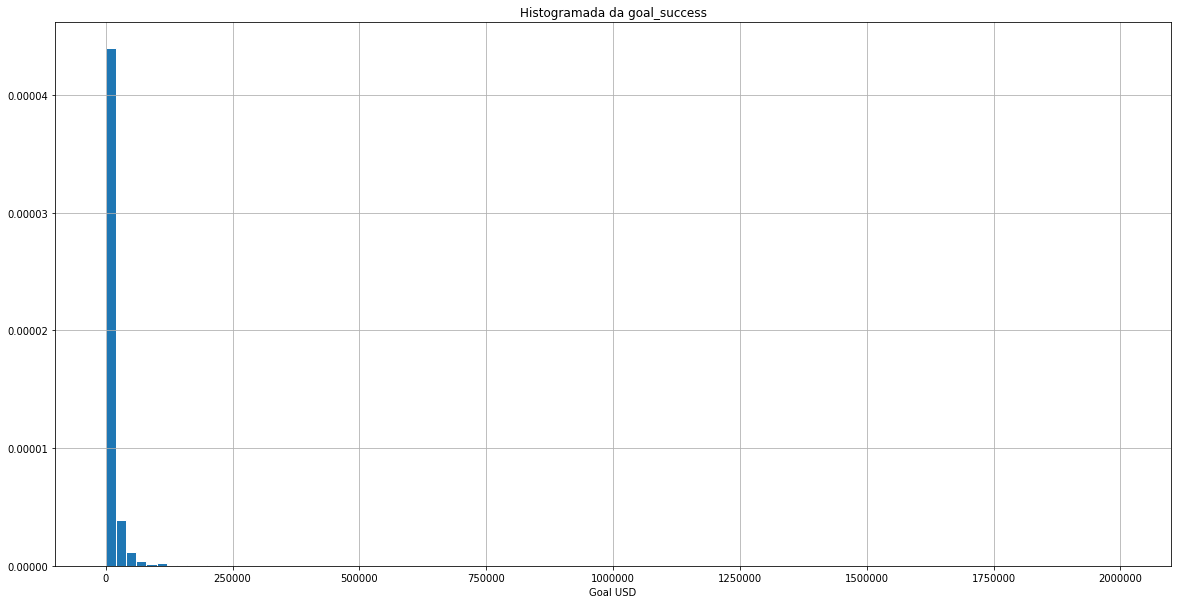

In [22]:
faixa_sucesso = np.arange(0,2.01561e+06,20000)

fig = plt.figure(figsize=(20, 10))
plt.hist(goal_success, bins = faixa_sucesso, edgecolor='white',density=True)
plt.title('Histogramada da goal_success')
plt.xlabel('Goal USD')
plt.ylabel('')
plt.grid()
plt.show()

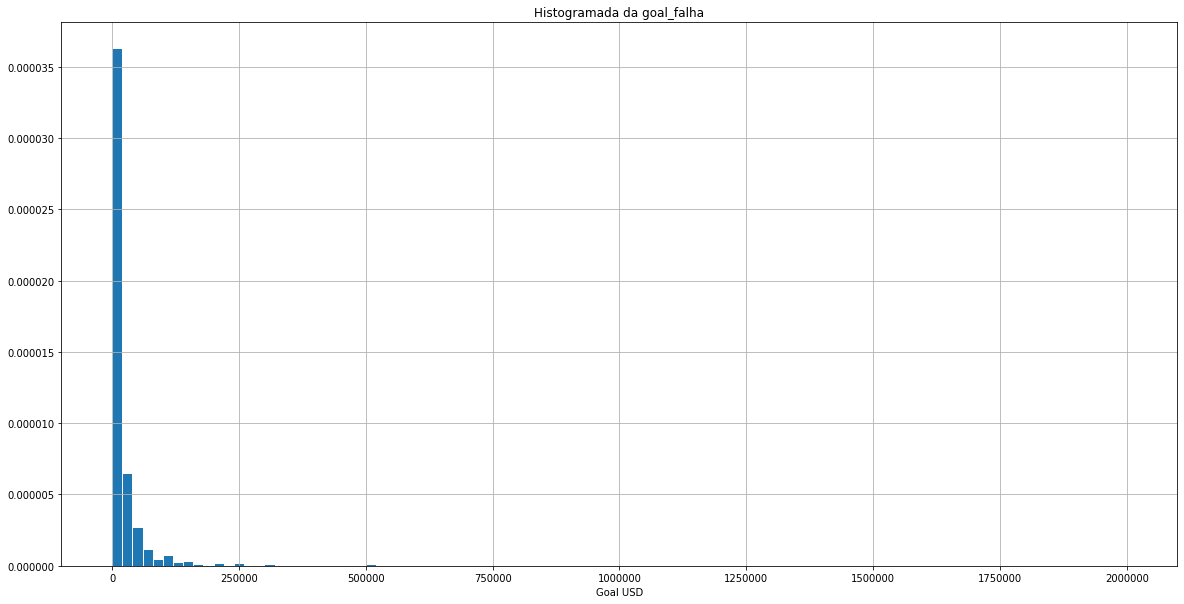

In [23]:
faixa_falha = np.arange(0,1.66361e+08,5000)

fig = plt.figure(figsize=(20, 10))
plt.hist(goal_falha, bins = faixa_sucesso, edgecolor='white', density = True)
plt.title('Histogramada da goal_falha')
plt.xlabel('Goal USD')
plt.ylabel('')
plt.grid()
plt.show()

Nesses dois histogramas acima, os objetivos de arrecadação final foram analisados. É possível notar que, quando o objetivo tem um valor muito baixo, a taxa de sucesso é maior que a taxa de falha. Também é possível notar que à medida que o valor do objetivo final aumenta, a taxa de falha supera o valor da taxa de sucesso. 

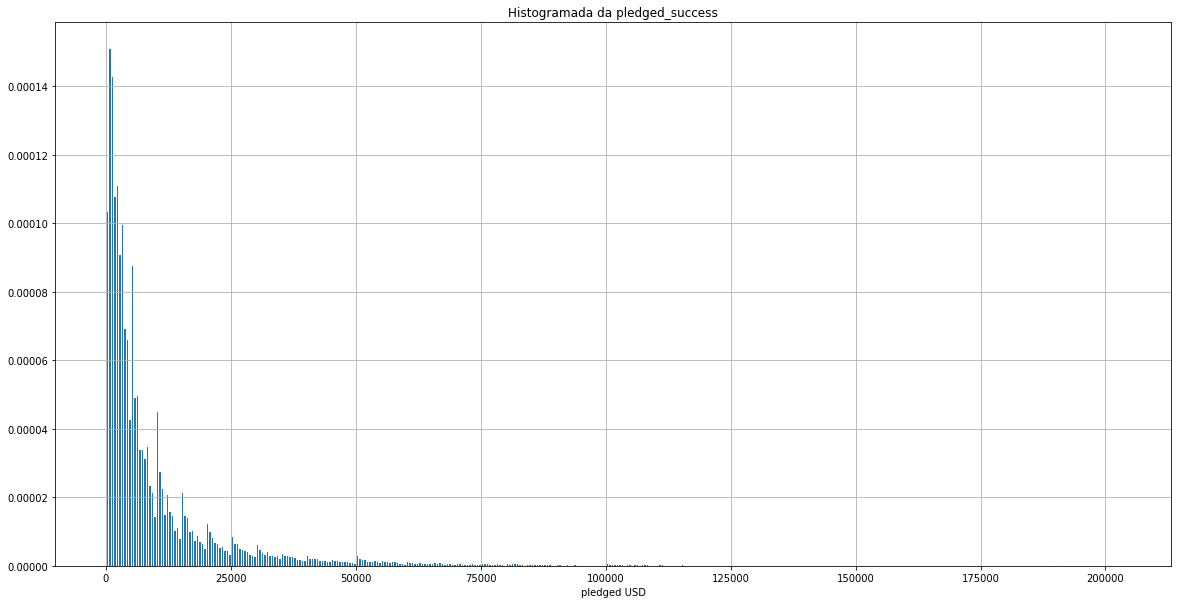

In [24]:
faixa_success_pledged = np.arange(0,2.0339e+05,500)

fig = plt.figure(figsize=(20, 10))
plt.hist(pledged_success, bins = faixa_success_pledged, edgecolor='white',density=True)
plt.title('Histogramada da pledged_success')
plt.xlabel('pledged USD')
plt.ylabel('')
plt.grid()
plt.show()

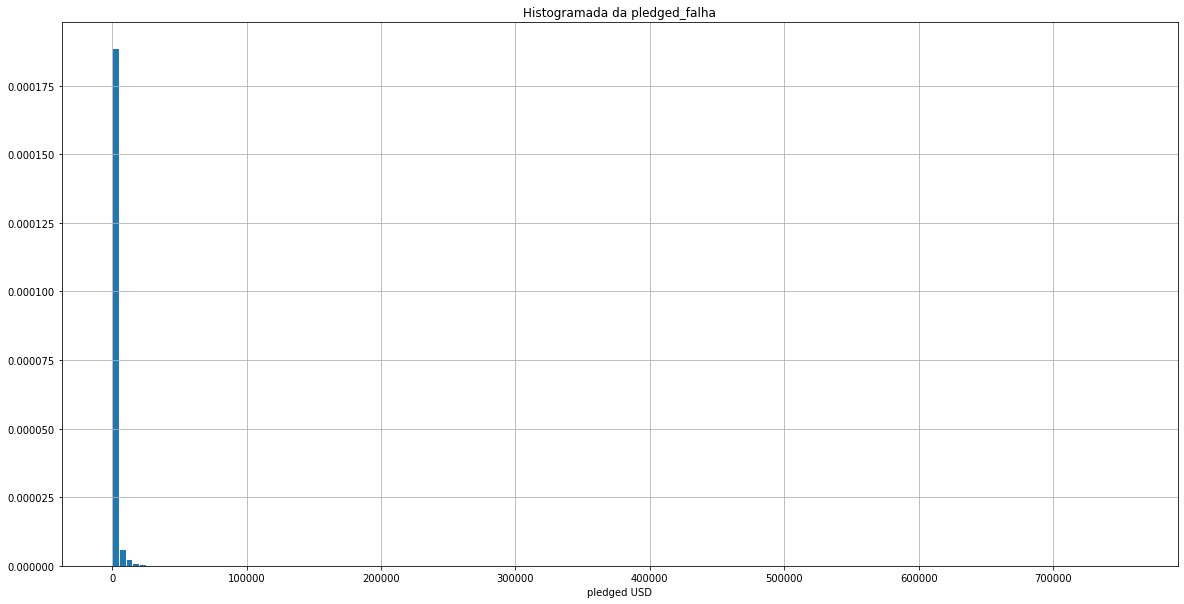

In [25]:
faixa_falha_pledged = np.arange(0,757353,5000)

fig = plt.figure(figsize=(20, 10))
plt.hist(pledged_falha, bins = faixa_falha_pledged, edgecolor='white',density=True)
plt.title('Histogramada da pledged_falha')
plt.xlabel('pledged USD')
plt.ylabel('')
plt.grid()
plt.show()

Ao analisar esses dois histogramas, é possível notar que quanto mais próximo de 0 é o valor prometido para o financiamento do projeto, maior é a taxa de falha. Além disso, podemos observar que quando esse valor aumenta, as  taxas de sucesso também aumentam e, em certo ponto, chegam a ultrapassar as taxas de falha.

In [26]:
dataset

,main_category,state,country,usd_pledged_real,usd_goal_real,delta_time,launched_Year,launched_Month
0,Publishing,failed,GB,0.0,1533.95,59,2015,8
1,Film & Video,failed,US,2421.0,30000.00,60,2017,9
2,Film & Video,failed,US,220.0,45000.00,45,2013,1
3,Music,failed,US,1.0,5000.00,30,2012,3
5,Food,successful,US,52375.0,50000.00,35,2016,2
...,...,...,...,...,...,...,...,...
378654,Food,failed,US,154.0,6500.00,30,2017,3
378657,Film & Video,failed,US,155.0,1500.00,27,2011,6
378658,Film & Video,failed,US,20.0,15000.00,46,2010,7
378659,Technology,failed,US,200.0,15000.00,31,2016,1


#### Ajustando o dataset para aplicar as técnicas:

In [27]:
dataset['state'] = dataset.state.map({'successful': 0,'failed': 1})
#tornando a variável 'state' em booleana
dataset

,main_category,state,country,usd_pledged_real,usd_goal_real,delta_time,launched_Year,launched_Month
0,Publishing,1,GB,0.0,1533.95,59,2015,8
1,Film & Video,1,US,2421.0,30000.00,60,2017,9
2,Film & Video,1,US,220.0,45000.00,45,2013,1
3,Music,1,US,1.0,5000.00,30,2012,3
5,Food,0,US,52375.0,50000.00,35,2016,2
...,...,...,...,...,...,...,...,...
378654,Food,1,US,154.0,6500.00,30,2017,3
378657,Film & Video,1,US,155.0,1500.00,27,2011,6
378658,Film & Video,1,US,20.0,15000.00,46,2010,7
378659,Technology,1,US,200.0,15000.00,31,2016,1


Criando as dummy variables para as variáveis categóricas.

In [28]:
for col in dataset.dtypes[dataset.dtypes == "category"].index:
    for_dummy = dataset.pop(col)
    dataset = pd.concat([dataset,pd.get_dummies(for_dummy,prefix=col)],axis=1)
dataset

,state,usd_pledged_real,usd_goal_real,delta_time,launched_Month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,...,launched_Year_2009,launched_Year_2010,launched_Year_2011,launched_Year_2012,launched_Year_2013,launched_Year_2014,launched_Year_2015,launched_Year_2016,launched_Year_2017,launched_Year_2018
0,1,0.0,1533.95,59,8,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,2421.0,30000.00,60,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,220.0,45000.00,45,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,1.0,5000.00,30,3,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,52375.0,50000.00,35,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,1,154.0,6500.00,30,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
378657,1,155.0,1500.00,27,6,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
378658,1,20.0,15000.00,46,7,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
378659,1,200.0,15000.00,31,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Separando nossa variável target das features a serem analisadas 

In [29]:
labels = dataset.pop('state')
dataset

,usd_pledged_real,usd_goal_real,delta_time,launched_Month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,...,launched_Year_2009,launched_Year_2010,launched_Year_2011,launched_Year_2012,launched_Year_2013,launched_Year_2014,launched_Year_2015,launched_Year_2016,launched_Year_2017,launched_Year_2018
0,0.0,1533.95,59,8,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2421.0,30000.00,60,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,220.0,45000.00,45,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1.0,5000.00,30,3,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,52375.0,50000.00,35,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,154.0,6500.00,30,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
378657,155.0,1500.00,27,6,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
378658,20.0,15000.00,46,7,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
378659,200.0,15000.00,31,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Dividindo o dataset em treinamento e teste.


In [30]:
x_train,x_test,y_train,y_test = train_test_split(dataset, labels,test_size=0.25)

In [31]:
features = x_train.columns
#alocando uma lista com as nossas features.

### Técnicas que utilizaremos:
#### Decision tree: 
São algorítimos usados para machine learning, que aplicam diversos cortes no dataset (leaf note), a partir de tomadas de decisões baseadas nas features de treinamento, afim de categorizar a target baseado na localização dela no dataset, o qual está dividido em diferentes áreas, que apresentam certo nível de homogeneidade, quanto a ocorrência da target do treinamento. O algorítimo leva em conta o índice de impuridade nas áreas de corte do dataset, no caso utilizamos o índice gini de impuridade. **Esse modelo enfrenta o problema de overfeating recorrente, devido ao número de cortes que ele realiza no dataset para treinar o modelo. ** 


#### Random Forest:
É um algoritimo utilizado para machine learning, que cria diversas decision trees utilizando o sorteio de algumas features do dataset, onde cada árvore individualmente, classifica a target. A resposta do algorítimo, leva em conta todas as classificações do dataset, sendo o output a que recebe mais votos. **Esse modelo utiliza o conceito de sabedoria das massas, no qual a associação de previsões de baixa acurácia se torna mais eficiente que um modelo de acurácia mais elevado.**

  - Embora se possa obter uma decision tree com acurácia mais alta que o random forest, para certa classificação, o random foresrt apresenta maior concistência ao trabalhar com datasets diferentes.
    
    
#### Logistic Regression:
Sendo um modelo de regressão uma técnica que permite inferir uma relação de multiplas variáveis a uma função relativa a variáveis independentes (features), tendo como resposta uma variável dependente (target). No caso da regressão logística, a aproximação é feita para uma função sigmoide que se assemelha a um S. O modelo é amplamente utilizado na classificação de variáveis target binárias, embora sendo uma regressão e associando um valor quantitativo se é estabelecido um threshold que o puxa para um dos valores de máximo ou mínimo da função, sendo neste caso, 0 e 1. Sendo estes valores nossas variáveis target escritas de forma binária. 

### Aplicando as técnicas:
#### Random Forest

Treinando o Random Forest Classifier para o nosso dataset de treinamento. Optamos por não colocar alguns parâmetros específicos, uma vez que iremos otimizá-los posteriormente. 

In [32]:
rf = RandomForestClassifier()
rf.fit(x_train,y_train)

C:\Users\JP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Testando o nosso modelo:

In [33]:
y_pred = rf.predict(x_test)

Conferindo a performance utilizando a curva de probabilidade roc, sendo auc o grau de distinção do nosso modelo.

In [34]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(false_positive_rate,true_possitive_rate)
roc_auc

0.9897003329069417

Analisando o resultado da acurácia do nosso modelo, é possível notar que ela está muito acima do esperado a ponto de ser incondizente com o modelo real.

Através da matriz de confusão desejamos validar nosso modelo, sabendo que essa tem como finalidade explicitar o viés de classificação do mesmo. 

In [35]:
confusion_matrix_1 = confusion_matrix(y_test, y_pred)
print(confusion_matrix_1)

[[33414   115]
 [  848 48542]]


Para melhor visualização, plotamos um gráfico, heatmap, a partir da biblioteca seaborn.

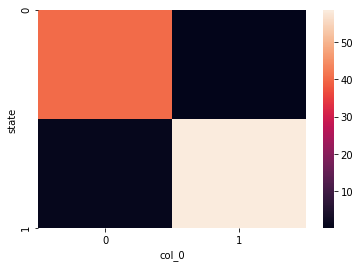

In [36]:
verificacao_5 = pd.crosstab(y_test, y_pred, normalize = True)*100
sns.heatmap(verificacao_5)
#fizemos crosstab para para associar duas variáveis qualitativas

Como a acurácia do nosso modelo foi extremamente alta não podemos ainda tirar conclusões sobre o viés do nosso modelo. 

#### Iterando o programa:

Após a revisão do código, notamos que uma das features escolhidas era uma variável incongruente, já que queriamos apenas features a priori da classificação final do estado do projeto. 

In [37]:
x_train = x_train.drop(columns = ['usd_pledged_real'])
x_test = x_test.drop(columns = ['usd_pledged_real'])
x_train

,usd_goal_real,delta_time,launched_Month,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,...,launched_Year_2009,launched_Year_2010,launched_Year_2011,launched_Year_2012,launched_Year_2013,launched_Year_2014,launched_Year_2015,launched_Year_2016,launched_Year_2017,launched_Year_2018
109103,8470.00,30,11,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
377605,9024.29,28,5,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
226326,1000.00,20,12,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
42579,5000.00,36,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
150772,10000.00,60,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358819,1260.00,11,7,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
107670,1554.48,28,6,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
362763,35000.00,40,12,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
313666,54000.00,56,11,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Rodando a iteração: 

In [38]:
rf_2 = RandomForestClassifier()
rf_2.fit(x_train,y_train)

C:\Users\JP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
y_pred_2 = rf_2.predict(x_test)

In [40]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_pred_2)
roc_auc_2 = auc(false_positive_rate,true_possitive_rate)
roc_auc_2

0.6025997961916979

Como o esperado a acurácia da nossa iteração é menor que a feita anteriormente, mas ainda sim congruente para o nosso modelo.

In [41]:
confusion_matrix_2 = confusion_matrix(y_test, y_pred_2)
print(confusion_matrix_2)

[[17486 16043]
 [15623 33767]]


Para melhor visualização, plotamos um gráfico, heatmap, a partir da biblioteca seaborn.

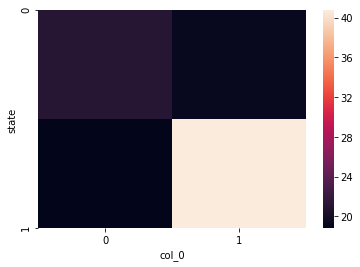

In [42]:
verificacao_6 = pd.crosstab(y_test, y_pred_2, normalize = True)*100
sns.heatmap(verificacao_6)
#fizemos crosstab para para associar duas variáveis qualitativas

O parâmetro n_estimators é a quantidade de desicion trees na nossa floresta. Desejamos otimizar tal parâmetro para aumentar a acurácia do nosso modelo sem aumentar muito o runtime. Para isso foi utilizado um laço for que permite gerar vários modelos random forest com diferentes números de decision trees, e compará-los, quanto a sua acurácia. 

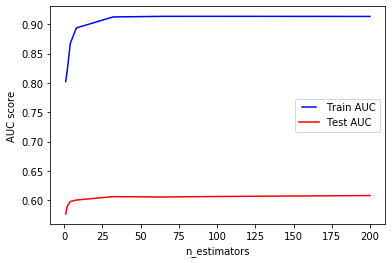

In [43]:
n_estimators = [1,2,4,8,32,64,100,200]

train_results = []
test_results = []

for estimators in n_estimators:
    RF = RandomForestClassifier(n_estimators=estimators, n_jobs=-1)
    RF.fit(x_train,y_train)
    train_pred = RF.predict(x_train)
    false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_train,train_pred)
    roc_auc = auc(false_positive_rate,true_possitive_rate)
    train_results.append(roc_auc)
    y_predict = RF.predict(x_test)
    false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_predict)
    roc_auc = auc(false_positive_rate,true_possitive_rate)
    test_results.append(roc_auc)
    
    

line1, = plt.plot(n_estimators, train_results, "b", label = "Train AUC")
line2, = plt.plot(n_estimators, test_results, "r",label = "Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

Notamos que a acurácia se estabiliza em torno de 30 estimators.

#### Decision Tree: comparando metodos de análise

Treinando o Decision Tree Classifier para o nosso dataset de treinamento. 

In [44]:
dt = tree.DecisionTreeClassifier(max_leaf_nodes = 10,random_state = 0)
dt = dt.fit(x_train, y_train)

#### Testando o nosso modelo:

In [45]:
y_prep_dt = dt.predict(x_train)

Conferindo a performance utilizando a curva de probabilidade roc, sendo auc o grau de distinção do nosso modelo.

In [46]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_train,y_prep_dt)
roc_auc_dt = auc(false_positive_rate,true_possitive_rate)
roc_auc_dt

0.5905593586366267

Analisando o resultado da acurácia do nosso modelo, é possível notar que ela está dentro do esperado. Notamos que a acurácia da Decision Tree está menor que o do Random Forest, isso acontece pois como a random forest é constituida por diversas decision trees, sua precisão tenderá a ser maior. Isso é um exemplo real da sabedoria das massas.

In [47]:
y_prep_dt = dt.predict(x_test)

In [48]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_prep_dt)
roc_auc_dt = auc(false_positive_rate,true_possitive_rate)
roc_auc_dt

0.5901018525809079

Através da matriz de confusão desejamos validar nosso modelo, sabendo que essa tem como finalidade explicitar o viés de classificação do mesmo.

In [49]:
confusion_matrix_3 = confusion_matrix(y_test, y_prep_dt)
print(confusion_matrix_3)

[[11847 21682]
 [ 8551 40839]]


Para melhor visualização, plotamos um gráfico, heatmap, a partir da biblioteca seaborn.

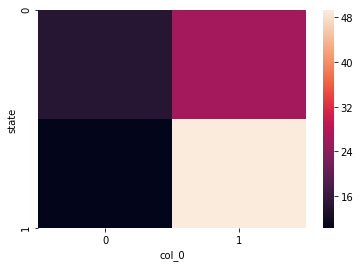

In [50]:
verificacao_7 = pd.crosstab(y_test, y_prep_dt, normalize = True)*100
sns.heatmap(verificacao_7)
#fizemos crosstab para para associar duas variáveis qualitativas

Notamos que o nosso modelo tende a categorizar muitas elementos como "failed", mostrando um problema comum de instabilidade do modelo de Decision Tree. 

Para melhor visualização do nosso modelo iremos plotar um esquema representando a nossa Decision Tree no qual os boxes representam os leaf_nodes. 

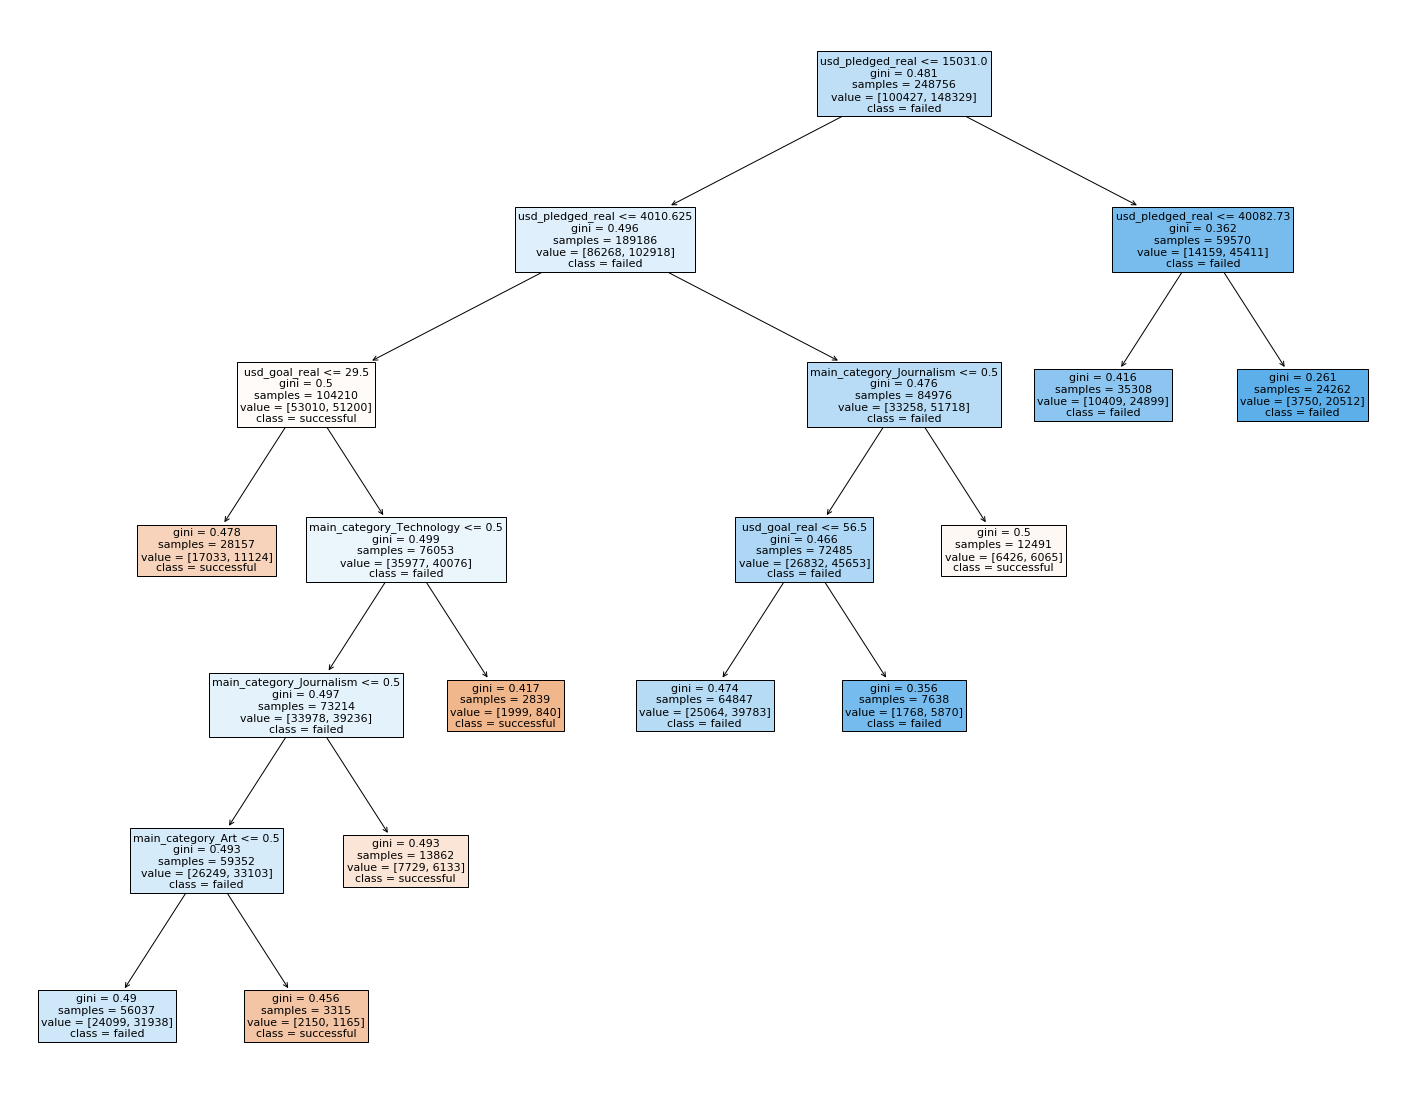

In [51]:
#ajustando o tamanho da figura
fig = plt.figure(figsize=(25,20))
#plotando nossa Decision Tree
grafico = tree.plot_tree(dt, feature_names= features,class_names=['successful','failed'],filled=True)

Semelhante ao Random Forest, o modelo de Decision Tree permite uma especificação, porém dessa vez no número de ramificações chamados no código de leaf_nodes, sendo essas os cortes feitos no dataset. Para isso foi utilizado um laço for que permite gerar vários modelos decision trees com diferentes números de nódulos, e compará-los, quanto a sua acurácia.

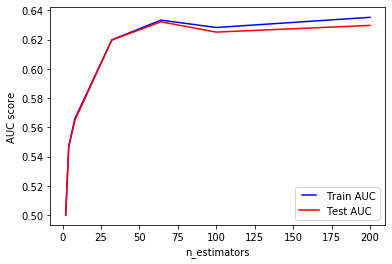

In [52]:
n_leaf_nodes = [None,2,4,8,32,64,100,200]

train_results_dt = []
test_results_dt = []

for num_nodes in n_leaf_nodes:
    DT = tree.DecisionTreeClassifier(max_leaf_nodes = num_nodes ,random_state = 0)
    DT = DT.fit(x_train, y_train)
    train_pred = DT.predict(x_train)
    false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_train,train_pred)
    roc_auc = auc(false_positive_rate,true_possitive_rate)
    train_results_dt.append(roc_auc)
    y_predict = DT.predict(x_test)
    false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_predict)
    roc_auc = auc(false_positive_rate,true_possitive_rate)
    test_results_dt.append(roc_auc)
    
    

line1, = plt.plot(n_leaf_nodes, train_results_dt, "b", label = "Train AUC")
line2, = plt.plot(n_leaf_nodes, test_results_dt, "r",label = "Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

Após feito o plot de comparações de decision tree com diferentes números de ramificações, é possível observar uma estabilização em 100 nodes.

#### Regressão Logistica

Treinando o Logistic Regression Classifier para o nosso dataset de treinamento.

Plotando a tabela de coeficientes da nossa regressão.

In [53]:
logit_model = sm.Logit(y_train,x_train)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.622951
         Iterations 10


LinAlgError: Singular matrix

Com os coeficientes tabelados é possível notar como certas features influenciam positivamente (coeficientes positivos) ou negativamente (coeficientes negativos), além de suas intensidades. A partir daí, é possível se concluir certas coisas como as categorias mais populares, sendo elas "journalism" e "crafts".

In [54]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

C:\Users\JP\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Testando o nosso modelo:

In [55]:
y_pred_Lrg = logreg.predict(x_test)

Conferindo a performance utilizando a curva de probabilidade roc, sendo auc o grau de distinção do nosso modelo.

In [56]:
false_positive_rate,true_possitive_rate, thresholds = roc_curve(y_test,y_pred_Lrg)
roc_auc_dt = auc(false_positive_rate,true_possitive_rate)
roc_auc_dt

0.5

Através da matriz de confusão desejamos validar nosso modelo, sabendo que essa tem como finalidade explicitar o viés de classificação do mesmo.

In [57]:
confusion_matrix_4 = confusion_matrix(y_test, y_pred_Lrg)
print(confusion_matrix_4)

[[    0 33529]
 [    0 49390]]


Para melhor visualização, plotamos um gráfico, heatmap, a partir da biblioteca seaborn.

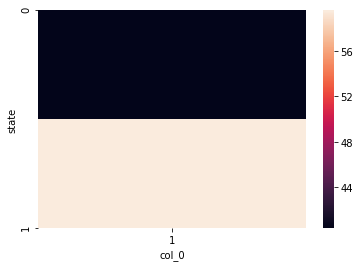

In [58]:
verificacao_8 = pd.crosstab(y_test, y_pred_Lrg, normalize = True)*100
sns.heatmap(verificacao_8)
#fizemos crosstab para para associar duas variáveis qualitativas

## Conclusão:


Ao final de todas essas aplicações de diferentes técnicas de análise no mesmo dataset, chegamos a algumas conclusões. Primeiramente, é necessário compreender a relevância e a importância de utilizar mais de uma técnica para a análise de uma série de dados, já que cada uma tem suas limitações e imperfeicões, fazendo com que a utilização conjunta de todas elas gere um resultado mais próximo da realidade. Além disso, é necessário levar em consideração que caso o dataset escolhido trabalhe com um conjunto de testes fixos a melhor técnica aser utilizada será a Decision Tree. Por outro lado, se o dataset variar a Random Forest será a melhor escolha para a análise dos dados. E por fim, a técnica de Regressão logística é importante para uma análise explorátoria mais profunda, já que ele compara os coeficientes das features revelando quais são as que mais afetam o resultado final. 

Tendo isso como base, a melhor técnica para uma análise mais completa do nosso dataset é o Random Forest, visto que a mesma oferece uma acurácia mais consistente e ela também apresenta uma possibilidade de expansão da aplicação do nosso classificador. 

**Proposta de Interface:**

É possível tornar nosso modelo acessível a qualquer um através de um site ou interface em HTML a qual capta o input do usuário sobre as features do seu projeto alocando elas em uma lista, que esta por sua vez será rodada no nosso classificador e devolverá como output a probabilidade de sucesso ou de falha (modelo.predict_proba(lista_input)). 